In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [42]:


# TODO: Task 1 

file1 = './historicalPriceData/ERCOT_DA_Prices_2016.csv'
file2 = './historicalPriceData/ERCOT_DA_Prices_2017.csv'
file3 = './historicalPriceData/ERCOT_DA_Prices_2018.csv'
file4 = './historicalPriceData/ERCOT_DA_Prices_2019.csv'

# Read the CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

# Combine the DataFrames into one
combined_df = pd.concat([df1, df2, df3, df4])

# Make sure the date column is in datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Sort the DataFrame by the date column
combined_df_sorted = combined_df.sort_values(by='Date')


# Display the sorted DataFrame
print(combined_df_sorted)

                      Date SettlementPoint  Price
0      2016-01-01 00:00:00       HB_BUSAVG  18.42
13     2016-01-01 00:00:00         LZ_WEST  18.44
12     2016-01-01 00:00:00        LZ_SOUTH  18.22
11     2016-01-01 00:00:00        LZ_RAYBN  18.43
9      2016-01-01 00:00:00         LZ_LCRA  18.44
...                    ...             ...    ...
129093 2019-12-31 23:00:00       HB_HUBAVG  14.45
129092 2019-12-31 23:00:00      HB_HOUSTON  14.45
129091 2019-12-31 23:00:00       HB_BUSAVG  14.46
129097 2019-12-31 23:00:00         HB_WEST  14.40
129105 2019-12-31 23:00:00         LZ_WEST  16.78

[497320 rows x 3 columns]


In [31]:
# TODO: Task 2 and 3

combined_df_sorted['Date'] = pd.to_datetime(combined_df_sorted['Date'])

# Create a new column for year-month
combined_df_sorted['YearMonth'] = combined_df_sorted['Date'].dt.to_period('M')

# Group by 'SettlementPoint' and 'YearMonth' and calculate the mean price
average_prices = combined_df_sorted.groupby(['SettlementPoint', 'YearMonth'])['Price'].mean().reset_index()

# Convert 'YearMonth' to a datetime to easily extract 'Year' and 'Month'
average_prices['YearMonth'] = average_prices['YearMonth'].dt.to_timestamp()

# Create 'Year' and 'Month' columns
average_prices['Year'] = average_prices['YearMonth'].dt.year
average_prices['Month'] = average_prices['YearMonth'].dt.month

# Drop the 'YearMonth' column as it's no longer needed
average_prices = average_prices.drop('YearMonth', axis=1)

# Rename the 'Price' column to 'AveragePrice'
average_prices.rename(columns={'Price': 'AveragePrice'}, inplace=True)

# Rearrange columns to match the required order
average_prices = average_prices[['SettlementPoint', 'Year', 'Month', 'AveragePrice']]

# Write the DataFrame to a CSV file
average_prices.to_csv('AveragePriceByMonth.csv', index=False)

print("CSV file 'AveragePriceByMonth.csv' has been created with the required columns.")
print(average_prices)

CSV file 'AveragePriceByMonth.csv' has been created with the required columns.
    SettlementPoint  Year  Month  AveragePrice
0         HB_BUSAVG  2016      1     19.209301
1         HB_BUSAVG  2016      2     15.288247
2         HB_BUSAVG  2016      3     16.755626
3         HB_BUSAVG  2016      4     18.289347
4         HB_BUSAVG  2016      5     18.159583
..              ...   ...    ...           ...
676         LZ_WEST  2019      8    128.876465
677         LZ_WEST  2019      9     83.471139
678         LZ_WEST  2019     10     49.383360
679         LZ_WEST  2019     11     49.340847
680         LZ_WEST  2019     12     39.502594

[681 rows x 4 columns]


In [50]:
#TODO: Bonus 1

# Create a 'Date' column for plotting
average_prices['Date'] = pd.to_datetime(average_prices['Year'].astype(str) + '-' + average_prices['Month'].astype(str) + '-01')

# Filter data for Hubs and Load Zones
hubs = average_prices[average_prices['SettlementPoint'].str.startswith('HB_')]
load_zones = average_prices[average_prices['SettlementPoint'].str.startswith('LZ_')]

# Function to plot data
def plot_data(df, title, filename):
    plt.figure(figsize=(10, 6))
    for label, grp in df.groupby('SettlementPoint'):
        plt.plot(grp['Date'], grp['AveragePrice'], label=label)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    plt.legend(title='SettlementPoint')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.savefig(filename)
    plt.close()  # Close the figure to avoid display in interactive mode

# Generate plots
plot_data(hubs, 'Monthly Average Prices for Settlement Hubs', 'SettlementHubAveragePriceByMonth.png')
plot_data(load_zones, 'Monthly Average Prices for Load Zones', 'LoadZoneAveragePriceByMonth.png')

In [52]:
# TODO: TAsk 4

# Convert 'Date' to datetime if it's not already
combined_df_sorted['Date'] = pd.to_datetime(combined_df_sorted['Date'])

# Filter for settlement points that are hubs and prices greater than zero
hub_data = combined_df_sorted[(combined_df_sorted['SettlementPoint'].str.startswith('HB_')) & (combined_df_sorted['Price'] > 0)]

# Calculate the natural logarithm of the prices
hub_data['LogPrice'] = np.log(hub_data['Price'])

# Calculate log returns
hub_data['LogReturn'] = hub_data.groupby('SettlementPoint')['LogPrice'].diff()

# Drop the first NaN value that occurs after the diff operation in each group
hub_data = hub_data.dropna(subset=['LogReturn'])

# Group by 'SettlementPoint' and year, and calculate the standard deviation of log returns
hub_data['Year'] = hub_data['Date'].dt.year
volatility = hub_data.groupby(['SettlementPoint', 'Year'])['LogReturn'].std().reset_index()

# Rename the column for clarity
volatility.rename(columns={'LogReturn': 'Volatility'}, inplace=True)

# Display the results
print(volatility)

   SettlementPoint  Year  Volatility
0        HB_BUSAVG  2016    0.185773
1        HB_BUSAVG  2017    0.154085
2        HB_BUSAVG  2018    0.200258
3        HB_BUSAVG  2019    0.249364
4       HB_HOUSTON  2016    0.191099
5       HB_HOUSTON  2017    0.170469
6       HB_HOUSTON  2018    0.200246
7       HB_HOUSTON  2019    0.247932
8        HB_HUBAVG  2016    0.187957
9        HB_HUBAVG  2017    0.158680
10       HB_HUBAVG  2018    0.202124
11       HB_HUBAVG  2019    0.250634
12        HB_NORTH  2016    0.184181
13        HB_NORTH  2017    0.152568
14        HB_NORTH  2018    0.200162
15        HB_NORTH  2019    0.249604
16          HB_PAN  2019    0.631635
17        HB_SOUTH  2016    0.209026
18        HB_SOUTH  2017    0.156138
19        HB_SOUTH  2018    0.198689
20        HB_SOUTH  2019    0.248966
21         HB_WEST  2016    0.208849
22         HB_WEST  2017    0.247615
23         HB_WEST  2018    0.302504
24         HB_WEST  2019    0.336588


C:\Users\Kinjalk Parth\AppData\Local\Temp\ipykernel_21828\670792204.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_data['LogPrice'] = np.log(hub_data['Price'])
C:\Users\Kinjalk Parth\AppData\Local\Temp\ipykernel_21828\670792204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_data['LogReturn'] = hub_data.groupby('SettlementPoint')['LogPrice'].diff()


In [53]:
# TODO: TASK 5

# Rename the 'Volatility' column to 'HourlyVolatility' 
volatility.rename(columns={'Volatility': 'HourlyVolatility'}, inplace=True)

# Write the DataFrame to a CSV file
volatility.to_csv('HourlyVolatilityByYear.csv', index=False)

print("CSV file 'HourlyVolatilityByYear.csv' has been created with the required columns.")

CSV file 'HourlyVolatilityByYear.csv' has been created with the required columns.


In [78]:
# TODO: Bonus 2

plt.figure(figsize=(12, 8))

# Create a pivot table for plotting to restructures the data for easy plotting with pandas
pivot_volatility = volatility.pivot(index='Year', columns='SettlementPoint', values='HourlyVolatility')

# Plotting
pivot_volatility.plot(kind='bar', width=0.8)
plt.title('Annual Volatility Comparison Across Settlement Hubs')
plt.xlabel('Year')
plt.ylabel('Volatility (Standard Deviation of Log Returns)')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical for readability
plt.legend(title='SettlementPoint', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to make room for legend

# Save the plot to a file in the output directory
output_directory = './output'
plt.savefig(f"{output_directory}/HubVolatilityByYear.png")
plt.close()  # Close the plot context to free up system resources

print(f"Volatility plot saved to {output_directory}/HubVolatilityByYear.png")

Volatility plot saved to ./output/HubVolatilityByYear.png


<Figure size 1200x800 with 0 Axes>

In [86]:
# TODO: Bonus 2

year_ticks = [2016, 2017, 2018, 2019]

# Pivot the data for easier plotting
pivot_volatility = volatility.pivot(index='Year', columns='SettlementPoint', values='HourlyVolatility')

# Plotting
plt.figure(figsize=(10, 6))
pivot_volatility.plot(marker='o', linestyle='-')
plt.title('Volatility Over Time by Settlement Hub')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend(title='SettlementPoint')
plt.xticks(year_ticks, [str(year) for year in year_ticks]) 
plt.grid(False)

plt.savefig(f"{output_directory}/HubVolatilityByYearLine.png")
plt.show()


<Figure size 1000x600 with 0 Axes>

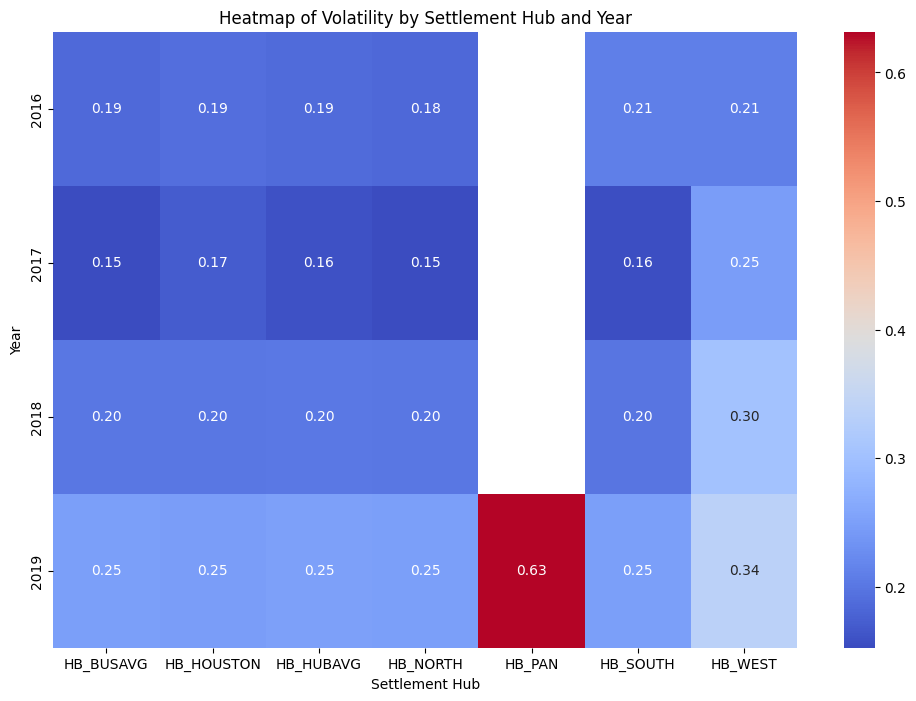

In [87]:
# TODO: Bonus 2

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_volatility, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Volatility by Settlement Hub and Year')
plt.xlabel('Settlement Hub')
plt.ylabel('Year')

plt.savefig(f"{output_directory}/HubVolatilityByYearHeatMap.png")
plt.show()



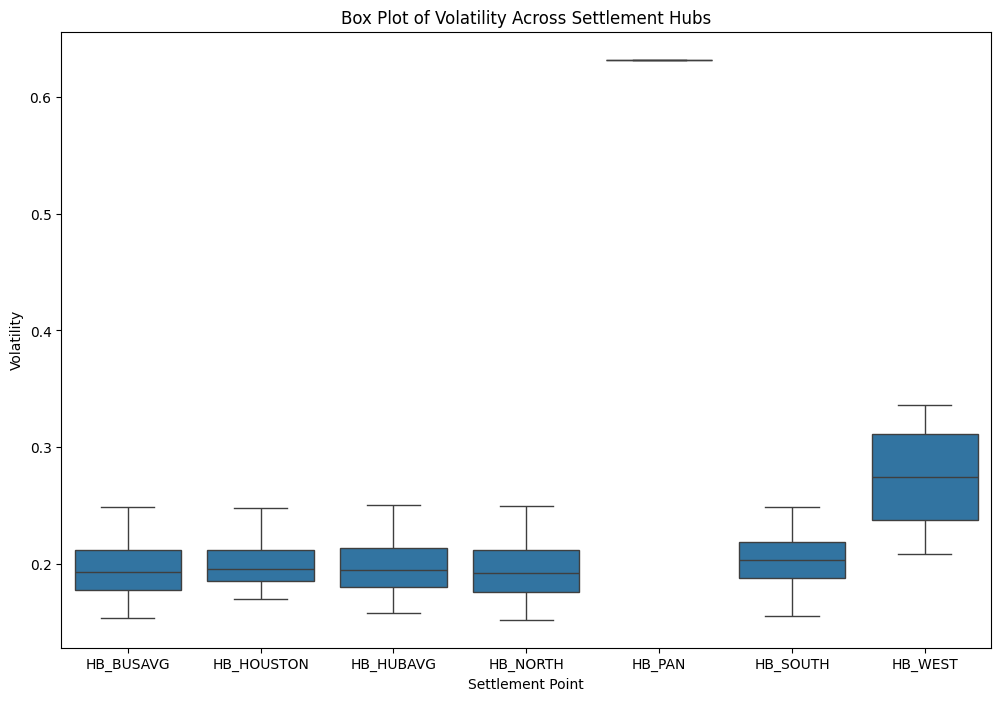

In [88]:
# TODO: Bonus 2

plt.figure(figsize=(12, 8))
sns.boxplot(data=volatility, x='SettlementPoint', y='HourlyVolatility')
plt.title('Box Plot of Volatility Across Settlement Hubs')
plt.xlabel('Settlement Point')
plt.ylabel('Volatility')
plt.savefig(f"{output_directory}/HubVolatilityByYearBoxPlot.png")
plt.show()



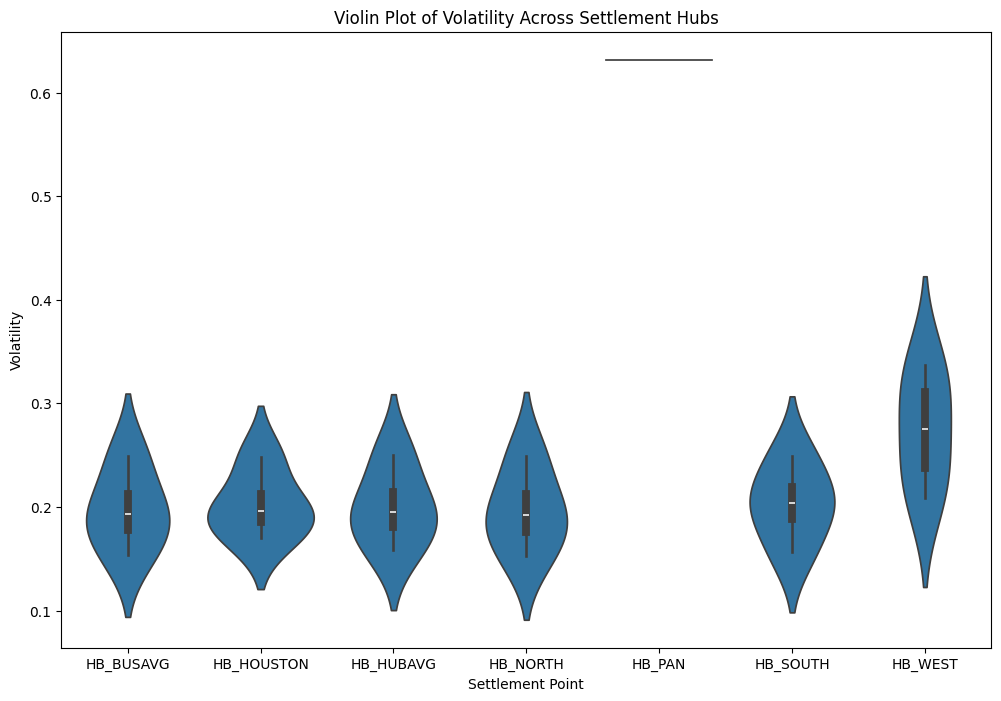

In [89]:
# TODO: Bonus 2

plt.figure(figsize=(12, 8))
sns.violinplot(data=volatility, x='SettlementPoint', y='HourlyVolatility')
plt.title('Violin Plot of Volatility Across Settlement Hubs')
plt.xlabel('Settlement Point')
plt.ylabel('Volatility')
plt.savefig(f"{output_directory}/HubVolatilityByYearViolinPlot.png")
plt.show()



In [58]:
# TODO: TASK 6

# Find the max volatility for each year
max_volatility_by_year = volatility.groupby('Year')['HourlyVolatility'].max().reset_index()

# Merge the max values back to the original dataframe to get the corresponding 'SettlementPoint'
max_volatility_rows = pd.merge(max_volatility_by_year, volatility, on=['Year', 'HourlyVolatility'], how='inner')

# Write the DataFrame to a CSV file named 'MaxVolatilityByYear.csv'
max_volatility_rows.to_csv('MaxVolatilityByYear.csv', index=False)

print("CSV file 'MaxVolatilityByYear.csv' has been created, containing the highest hourly volatility for each year.")

CSV file 'MaxVolatilityByYear.csv' has been created, containing the highest hourly volatility for each year.


In [73]:
# TODO: TASK 7

# Convert 'Date' to datetime type if not already
combined_df_sorted['Date'] = pd.to_datetime(combined_df_sorted['Date'])

# Create separate Date and Hour columns
combined_df_sorted['JustDate'] = combined_df_sorted['Date'].dt.date
combined_df_sorted['Hour'] = combined_df_sorted['Date'].dt.hour

# Prepare directory for output
output_directory = './formattedSpotHistory'
os.makedirs(output_directory, exist_ok=True)

# Process each unique settlement point
for point in combined_df_sorted['SettlementPoint'].unique():
    # Filter data for the current settlement point
    temp_df = combined_df_sorted[combined_df_sorted['SettlementPoint'] == point]
    
    # Pivot table to transform data into the desired format
    pivot_df = temp_df.pivot_table(index='JustDate', columns='Hour', values='Price', aggfunc='first')
    
    # Ensure all hours 0-23 are represented, even if some are NaN
    pivot_df = pivot_df.reindex(columns=range(24))
    
    # Rename columns from 0-23 to X1-X24
    pivot_df.columns = [f'X{i+1}' for i in range(0, 24)]
    
    # Reset index to turn the index into columns
    pivot_df.reset_index(inplace=True)
    
    # Add the PriceVariable (SettlementPoint) column
    pivot_df['PriceVariable'] = point
    
    # Rearrange columns to have 'PriceVariable', 'JustDate', 'X1', ..., 'X24'
    pivot_df = pivot_df[['PriceVariable', 'JustDate'] + [f'X{i+1}' for i in range(0, 24)]]
    pivot_df.rename(columns={'JustDate': 'Date'}, inplace=True)
    # Save the DataFrame to a CSV file
    filename = f"spot_{point}.csv"
    
    pivot_df.to_csv(os.path.join(output_directory, filename), index=False)

print(f"Data files for each settlement point have been created in the directory: {output_directory}")

Data files for each settlement point have been created in the directory: ./formattedSpotHistory


In [75]:
# TODO: Bonus 3

combined_df_sorted['Date'] = pd.to_datetime(combined_df_sorted['Date'])

# Extract Month, Day of Week, and Hour from 'Date'
combined_df_sorted['Month'] = combined_df_sorted['Date'].dt.month
combined_df_sorted['DayOfWeek'] = combined_df_sorted['Date'].dt.dayofweek
combined_df_sorted['Hour'] = combined_df_sorted['Date'].dt.hour

# Group by SettlementPoint, Month, DayOfWeek, and Hour
grouped = combined_df_sorted.groupby(['SettlementPoint', 'Month', 'DayOfWeek', 'Hour'])['Price'].mean().reset_index()

# Normalize the hourly prices
def normalize(group):
    hourly_sum = group['Price'].sum()
    group['NormalizedPrice'] = group['Price'] / hourly_sum * 24  # Ensuring sum equals 24, thus average equals 1
    return group

# Apply normalization
normalized_profiles = grouped.groupby(['SettlementPoint', 'Month', 'DayOfWeek']).apply(normalize)

# Directory setup
output_dir = 'hourlyShapeProfiles'
os.makedirs(output_dir, exist_ok=True)

# Save each SettlementPoint's profile to a separate CSV file
for settlement_point in normalized_profiles['SettlementPoint'].unique():
    subset = normalized_profiles[normalized_profiles['SettlementPoint'] == settlement_point]
    filename = f"profile_{settlement_point}.csv"
    subset = subset[['Month', 'DayOfWeek', 'Hour', 'NormalizedPrice']]
    subset.to_csv(os.path.join(output_dir, filename), index=False)

print(f"Hourly shape profiles have been saved in the directory: {output_dir}")


Hourly shape profiles have been saved in the directory: hourlyShapeProfiles
